In [29]:
import csv
import numpy as np
import pandas as pd
import itertools

from sklearn.metrics import confusion_matrix

import cv2
from matplotlib import pyplot as plt

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


In [2]:
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# remove prefixes
import os
path = '/media/stanislau/82db778e-0496-450c-9b25-d1e50a90e476/data/data4stas/01_data_cls/'
os.chdir(path)

In [ ]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [4]:
import scipy.ndimage as ndi

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='nearest',
                    cval=0.):
    """Apply the image transformation specified by a matrix.

    # Arguments
        x: 2D numpy array, single image.
        transform_matrix: Numpy array specifying the geometric transformation.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.

    # Returns
        The transformed version of the input.
    """
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(
        x_channel,
        final_affine_matrix,
        final_offset,
        order=0,
        mode=fill_mode,
        cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x

class BrodatzImageDataGenerator(ImageDataGenerator):
    def random_transform(self, x, seed=None):
        """Randomly augment a single image tensor.

        # Arguments
            x: 3D tensor, single image.
            seed: random seed.

        # Returns
            A randomly transformed version of the input (same shape).
        """
        # x is a single image, so it doesn't have image number at index 0
        img_row_axis = self.row_axis - 1
        img_col_axis = self.col_axis - 1
        img_channel_axis = self.channel_axis - 1

        if seed is not None:
            np.random.seed(seed)

        # use composition of homographies
        # to generate final transform that needs to be applied
        if self.rotation_range:
            theta = np.pi / 180 * np.random.uniform(-self.rotation_range, self.rotation_range)
        else:
            theta = 0

        if self.height_shift_range:
            tx = np.random.uniform(-self.height_shift_range, self.height_shift_range) * x.shape[img_row_axis]
        else:
            tx = 0

        if self.width_shift_range:
            ty = np.random.uniform(-self.width_shift_range, self.width_shift_range) * x.shape[img_col_axis]
        else:
            ty = 0

        if self.shear_range:
            shear = np.random.uniform(-self.shear_range, self.shear_range)
        else:
            shear = 0

        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            zx, zy = 1, 1
        else:
            if np.random.random() < 0.5:
                zx = zy = self.zoom_range[0] + np.random.uniform(-0.05, 0.05)
            else:
                zx = zy = self.zoom_range[1] + np.random.uniform(-0.05, 0.05)

        transform_matrix = None
        if theta != 0:
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                        [np.sin(theta), np.cos(theta), 0],
                                        [0, 0, 1]])
            transform_matrix = rotation_matrix

        if tx != 0 or ty != 0:
            shift_matrix = np.array([[1, 0, tx],
                                     [0, 1, ty],
                                     [0, 0, 1]])
            transform_matrix = shift_matrix if transform_matrix is None else np.dot(transform_matrix, shift_matrix)

        if shear != 0:
            shear_matrix = np.array([[1, -np.sin(shear), 0],
                                    [0, np.cos(shear), 0],
                                    [0, 0, 1]])
            transform_matrix = shear_matrix if transform_matrix is None else np.dot(transform_matrix, shear_matrix)

        if zx != 1 or zy != 1:
            zoom_matrix = np.array([[zx, 0, 0],
                                    [0, zy, 0],
                                    [0, 0, 1]])
            transform_matrix = zoom_matrix if transform_matrix is None else np.dot(transform_matrix, zoom_matrix)

        if transform_matrix is not None:
            h, w = x.shape[img_row_axis], x.shape[img_col_axis]
            transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
            x = apply_transform(x, transform_matrix, img_channel_axis,
                                fill_mode=self.fill_mode, cval=self.cval)

        if self.channel_shift_range != 0:
            x = random_channel_shift(x,
                                     self.channel_shift_range,
                                     img_channel_axis)
        if self.horizontal_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_col_axis)

        if self.vertical_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_row_axis)

        return x

In [142]:
def process_file(path):
    df = pd.read_csv(path)
    
    x = []
    y = []
    filenames = []

    for index, row in df.iterrows():
        x.append(cv2.imread(row[0], cv2.IMREAD_GRAYSCALE))
        y.append(float(row[1]))

    x = np.array(x)
    y = np.array(y)
    
    num_classes = len(np.unique(y))

    x = x.astype('float32') / 255
    x -= np.mean(x, axis=1, keepdims=True)
    x /= (np.std(x, axis=1, keepdims=True) + 1e-7)
    x = x.reshape(x.shape + (-1,))
    
    y = y - 1
    y = keras.utils.to_categorical(y, num_classes=num_classes)

    return x, y, num_classes

def probas_to_classes(y_prob):
    return np.argmax(y_prob, axis=1) + 1

def accuracy(y_test, y_predict):
    return np.sum(np.argmax(y_predict, axis=1) == np.argmax(y_test, axis=1))/y_predict.shape[0]

def process_file_some_classes(path, classes):
    df = pd.read_csv(path)
    
    x = []
    y = []

    for index, row in df.iterrows():
        x.append(cv2.imread(row['FilePath'], cv2.IMREAD_GRAYSCALE))
        y.append(float(row['ClassId']))

    x = np.array(x)
    y = np.array(y) - 1
        
    num_classes = len(classes)

    x = x.astype('float32') / 255
    x -= np.mean(x, axis=1, keepdims=True)
    x /= (np.std(x, axis=1, keepdims=True) + 1e-7)
    x = x.reshape(x.shape + (-1,))
    
    x = x[np.in1d(y, classes)]
    y = y[np.in1d(y, classes)]
    
    y = y - np.min(y)
    
    y = keras.utils.to_categorical(y, num_classes=num_classes)

    return x, y, num_classes

def process_line(line):
    pass

def generate_arrays_from_file(path):
    df = pd.read_csv(path)
    
    while 1:
        f = open(path)
        for line in f:
            # create numpy arrays of input data
            # and labels, from each line in the file
            x1, x2, y = process_line(line)
            yield ({'input_1': x1, 'input_2': x2}, {'output': y})
        f.close()
        
def plot(x):
    plt.imshow(x.reshape(x.shape[:-1]), cmap=plt.cm.gray)
    plt.show()
    
def model_1(num_classes):
    model = Sequential()
    # input: 200x200 grayscale images -> (200, 200, 1) tensors.
    # this applies 8 convolution filters of size 3x3 each.
    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(200, 200, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
#     model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
#     model.add(Dropout(0.5))
    model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.01), activation='softmax'), )

#     sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    adam = keras.optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def fit_1(model, x, y, classes, batch_size=32, epochs=100):
    x_test, y_test, num_classes = process_file_some_classes('Alexander_cls_test.csv', classes)
    return model.fit(x, y, batch_size=50, epochs=epochs, validation_data=(x_test, y_test))

def fit_generator_1(model, x, y, classes, batch_size=32, epochs=100, validation=False):
    datagen = ImageDataGenerator(
        rotation_range=np.pi / 4,
        shear_range=np.pi / 5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.5,
        fill_mode='nearest')
    
    validation_data = None
    if (validation):
        x_test, y_test, num_classes = process_file_some_classes('Alexander_cls_test.csv', classes)
        validation_data = (x_test, y_test)
        
    return model.fit_generator(datagen.flow(x, y, batch_size=batch_size), validation_data=validation_data,
                    steps_per_epoch=len(x) / batch_size, epochs=epochs)

def test_1(model, classes, batch_size=32):
    test_paths = ['Alexander_cls_train.csv',
                 'Alexander_cls_test.csv',
                 'Alexander_cls_test1.csv',
                 'Alexander_cls_test2.csv',
                 'Alexander_cls_test3.csv',
                 'Alexander_cls_test4.csv']

    for test_path in test_paths:
        x_test, y_test, num_classes = process_file_some_classes(test_path, classes)
        score = model.evaluate(x_test, y_test, batch_size=batch_size)
        print(test_path + ' : ' + ', '.join(str(x) for x in score))
        
def pipe_1():
    classes = np.arange(0, 15)
    x, y, num_classes = process_file_some_classes('Alexander_cls_train.csv', classes)
    
    model = model_1(num_classes)
    
    batch_size = 50
    epochs = 30
    history = fit_1(model, x, y, classes, batch_size, epochs)
    test_1(model, classes, batch_size)
    return history

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history.get('val_acc')
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    
    epochs = range(1, len(loss) + 1)
    
    plt.plot(epochs, loss)
    if val_loss is not None:
        plt.plot(epochs, val_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(epochs, acc)
    if val_acc is not None:
        plt.plot(epochs, val_acc)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

def predict_1(model, classes):
    x_test, y_test, num_classes = process_file_some_classes('Alexander_cls_test.csv', classes)
    y_predict = model.predict(x_test, batch_size=32)
    
def save_model(model):
    path = '/media/stanislau/82db778e-0496-450c-9b25-d1e50a90e476/data/data4stas/brodaz'
    current_dir = os.getcwd()
    os.chdir(path)

    input_filename = 'brodatz_dataset_test_submit.csv'
    output_filename = 'brodatz_dataset_test_submit_0'    
    
    x_test, y_test, num_classes = process_file(input_filename)
    df = pd.read_csv(input_filename)
    y_pred = model.predict_classes(x_test) + 1
    df[df.columns[1]] = y_pred
    df.to_csv(output_filename, index=False)
    
    os.chdir(current_dir)

def hybrid_model1():
    classes = np.arange(0, 40)
    x, y, num_classes = process_file_some_classes('Alexander_cls_train.csv', classes)
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
save_model(model)

In [ ]:
x, y, num_classes = process_file('Alexander_cls_train.csv')

In [ ]:
[plot(img) for img in x[probas_to_classes(y) == 1]]

In [151]:
classes = np.arange(0, 36)
x, y, num_classes = process_file_some_classes('Alexander_cls_train.csv', classes)

In [144]:
model = model_1(num_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 198, 198, 64)      640       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 97, 97, 128)       73856     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 46, 46, 256)       295168    
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 23, 23, 256)       0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 135424)            0         
__________

Epoch 1/800
2/1 [==============================] - 1s - loss: 7.1207 - acc: 0.0217     
Epoch 2/800
2/1 [==============================] - 0s - loss: 6.8697 - acc: 0.0279     
Epoch 3/800
2/1 [==============================] - 0s - loss: 6.7475 - acc: 0.0331     
Epoch 4/800
2/1 [==============================] - 0s - loss: 6.6461 - acc: 0.0442     
Epoch 5/800
2/1 [==============================] - 0s - loss: 6.5356 - acc: 0.0662     
Epoch 6/800
2/1 [==============================] - 0s - loss: 6.4392 - acc: 0.0929     
Epoch 7/800
2/1 [==============================] - 0s - loss: 6.2977 - acc: 0.1213     
Epoch 8/800
2/1 [==============================] - 0s - loss: 6.1628 - acc: 0.1559     
Epoch 9/800
2/1 [==============================] - 0s - loss: 6.0246 - acc: 0.1767     
Epoch 10/800
2/1 [==============================] - 0s - loss: 5.8789 - acc: 0.1549     
Epoch 11/800
2/1 [==============================] - 0s - loss: 5.7029 - acc: 0.2056     
Epoch 12/800
2/1 [============

2/1 [==============================] - 0s - loss: 3.0906 - acc: 0.6607     
Epoch 94/800
2/1 [==============================] - 0s - loss: 2.9821 - acc: 0.7447     
Epoch 95/800
2/1 [==============================] - 0s - loss: 3.1232 - acc: 0.6882     
Epoch 96/800
2/1 [==============================] - 0s - loss: 3.0869 - acc: 0.6874     
Epoch 97/800
2/1 [==============================] - 0s - loss: 2.9169 - acc: 0.6995     
Epoch 98/800
2/1 [==============================] - 0s - loss: 3.1642 - acc: 0.5992     
Epoch 99/800
2/1 [==============================] - 0s - loss: 3.0568 - acc: 0.6513     
Epoch 100/800
2/1 [==============================] - 0s - loss: 3.0305 - acc: 0.6770     
Epoch 101/800
2/1 [==============================] - 0s - loss: 3.0342 - acc: 0.7324     
Epoch 102/800
2/1 [==============================] - 0s - loss: 2.9426 - acc: 0.7492     
Epoch 103/800
2/1 [==============================] - 0s - loss: 3.0063 - acc: 0.6783     
Epoch 104/800
2/1 [===========

2/1 [==============================] - 0s - loss: 2.5029 - acc: 0.7779     
Epoch 185/800
2/1 [==============================] - 0s - loss: 2.5543 - acc: 0.7623     
Epoch 186/800
2/1 [==============================] - 0s - loss: 2.4639 - acc: 0.7999     
Epoch 187/800
2/1 [==============================] - 0s - loss: 2.4779 - acc: 0.8053     
Epoch 188/800
2/1 [==============================] - 0s - loss: 2.4007 - acc: 0.8223     
Epoch 189/800
2/1 [==============================] - 0s - loss: 2.4049 - acc: 0.8065     
Epoch 190/800
2/1 [==============================] - 0s - loss: 2.3851 - acc: 0.8213     
Epoch 191/800
2/1 [==============================] - 0s - loss: 2.5102 - acc: 0.7606     
Epoch 192/800
2/1 [==============================] - 0s - loss: 2.3923 - acc: 0.8171     
Epoch 193/800
2/1 [==============================] - 0s - loss: 2.3973 - acc: 0.7835     
Epoch 194/800
2/1 [==============================] - 0s - loss: 2.3660 - acc: 0.8280     
Epoch 195/800
2/1 [=====

2/1 [==============================] - 0s - loss: 2.2258 - acc: 0.7929     
Epoch 276/800
2/1 [==============================] - 0s - loss: 2.1930 - acc: 0.7949     
Epoch 277/800
2/1 [==============================] - 0s - loss: 2.1132 - acc: 0.8335     
Epoch 278/800
2/1 [==============================] - 0s - loss: 2.2062 - acc: 0.8288     
Epoch 279/800
2/1 [==============================] - 0s - loss: 2.1198 - acc: 0.8386     
Epoch 280/800
2/1 [==============================] - 0s - loss: 2.2247 - acc: 0.8058     
Epoch 281/800
2/1 [==============================] - 0s - loss: 2.1195 - acc: 0.8606     
Epoch 282/800
2/1 [==============================] - 0s - loss: 2.1656 - acc: 0.7996     
Epoch 283/800
2/1 [==============================] - 0s - loss: 2.1035 - acc: 0.8280     
Epoch 284/800
2/1 [==============================] - 0s - loss: 2.0214 - acc: 0.8616     
Epoch 285/800
2/1 [==============================] - 0s - loss: 2.0582 - acc: 0.8562     
Epoch 286/800
2/1 [=====

2/1 [==============================] - 0s - loss: 1.9082 - acc: 0.8774     
Epoch 367/800
2/1 [==============================] - 0s - loss: 1.8951 - acc: 0.8831     
Epoch 368/800
2/1 [==============================] - 0s - loss: 2.1037 - acc: 0.7949     
Epoch 369/800
2/1 [==============================] - 0s - loss: 1.9628 - acc: 0.8401     
Epoch 370/800
2/1 [==============================] - 0s - loss: 2.0295 - acc: 0.8213     
Epoch 371/800
2/1 [==============================] - 0s - loss: 1.9708 - acc: 0.8433     
Epoch 372/800
2/1 [==============================] - 0s - loss: 1.9489 - acc: 0.8616     
Epoch 373/800
2/1 [==============================] - 0s - loss: 1.9879 - acc: 0.8105     
Epoch 374/800
2/1 [==============================] - 0s - loss: 1.9454 - acc: 0.8288     
Epoch 375/800
2/1 [==============================] - 0s - loss: 1.8827 - acc: 0.8782     
Epoch 376/800
2/1 [==============================] - 0s - loss: 1.8993 - acc: 0.8663     
Epoch 377/800
2/1 [=====

2/1 [==============================] - 0s - loss: 1.7723 - acc: 0.8720     
Epoch 458/800
2/1 [==============================] - 0s - loss: 1.7238 - acc: 0.8671     
Epoch 459/800
2/1 [==============================] - 0s - loss: 1.8066 - acc: 0.8384     
Epoch 460/800
2/1 [==============================] - 0s - loss: 1.7114 - acc: 0.8720     
Epoch 461/800
2/1 [==============================] - 0s - loss: 1.7645 - acc: 0.8826     
Epoch 462/800
2/1 [==============================] - 0s - loss: 1.7737 - acc: 0.8616     
Epoch 463/800
2/1 [==============================] - 0s - loss: 1.7456 - acc: 0.8505     
Epoch 464/800
2/1 [==============================] - 0s - loss: 1.7071 - acc: 0.8616     
Epoch 465/800
2/1 [==============================] - 0s - loss: 1.6730 - acc: 0.8942     
Epoch 466/800
2/1 [==============================] - 0s - loss: 1.7395 - acc: 0.8503     
Epoch 467/800
2/1 [==============================] - 0s - loss: 1.7384 - acc: 0.8718     
Epoch 468/800
2/1 [=====

2/1 [==============================] - 0s - loss: 1.6843 - acc: 0.8503     
Epoch 549/800
2/1 [==============================] - 0s - loss: 1.6857 - acc: 0.8164     
Epoch 550/800
2/1 [==============================] - 0s - loss: 1.6474 - acc: 0.8446     
Epoch 551/800
2/1 [==============================] - 0s - loss: 1.6457 - acc: 0.8937     
Epoch 552/800
2/1 [==============================] - 0s - loss: 1.6638 - acc: 0.8762     
Epoch 553/800
2/1 [==============================] - 0s - loss: 1.5020 - acc: 0.9442     
Epoch 554/800
2/1 [==============================] - 0s - loss: 1.7268 - acc: 0.8384     
Epoch 555/800
2/1 [==============================] - 0s - loss: 1.7141 - acc: 0.8278     
Epoch 556/800
2/1 [==============================] - 0s - loss: 1.6037 - acc: 0.8999     
Epoch 557/800
2/1 [==============================] - 0s - loss: 1.6839 - acc: 0.8616     
Epoch 558/800
2/1 [==============================] - 0s - loss: 1.6411 - acc: 0.8888     
Epoch 559/800
2/1 [=====

2/1 [==============================] - 0s - loss: 1.5892 - acc: 0.8554     
Epoch 640/800
2/1 [==============================] - 0s - loss: 1.6159 - acc: 0.8723     
Epoch 641/800
2/1 [==============================] - 0s - loss: 1.6009 - acc: 0.8498     
Epoch 642/800
2/1 [==============================] - 0s - loss: 1.5400 - acc: 0.8500     
Epoch 643/800
2/1 [==============================] - 0s - loss: 1.5419 - acc: 0.8886     
Epoch 644/800
2/1 [==============================] - 0s - loss: 1.5304 - acc: 0.8997     
Epoch 645/800
2/1 [==============================] - 0s - loss: 1.5269 - acc: 0.8883     
Epoch 646/800
2/1 [==============================] - 0s - loss: 1.5698 - acc: 0.8550     
Epoch 647/800
2/1 [==============================] - 0s - loss: 1.5090 - acc: 0.9064     
Epoch 648/800
2/1 [==============================] - 0s - loss: 1.4861 - acc: 0.9098     
Epoch 649/800
2/1 [==============================] - 0s - loss: 1.5161 - acc: 0.8886     
Epoch 650/800
2/1 [=====

2/1 [==============================] - 0s - loss: 1.4581 - acc: 0.8893     
Epoch 731/800
2/1 [==============================] - 0s - loss: 1.4956 - acc: 0.8668     
Epoch 732/800
2/1 [==============================] - 0s - loss: 1.3870 - acc: 0.8883     
Epoch 733/800
2/1 [==============================] - 0s - loss: 1.3842 - acc: 0.9051     
Epoch 734/800
2/1 [==============================] - 0s - loss: 1.3893 - acc: 0.9054     
Epoch 735/800
2/1 [==============================] - 0s - loss: 1.4456 - acc: 0.8945     
Epoch 736/800
2/1 [==============================] - 0s - loss: 1.3673 - acc: 0.9054     
Epoch 737/800
2/1 [==============================] - 0s - loss: 1.4488 - acc: 0.8787     
Epoch 738/800
2/1 [==============================] - 0s - loss: 1.4877 - acc: 0.8550     
Epoch 739/800
2/1 [==============================] - 0s - loss: 1.4480 - acc: 0.8616     
Epoch 740/800
2/1 [==============================] - 0s - loss: 1.4498 - acc: 0.8661     
Epoch 741/800
2/1 [=====

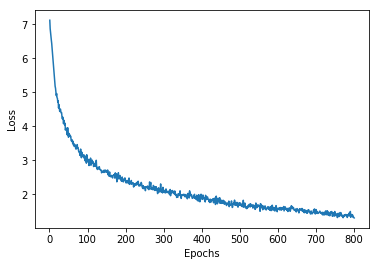

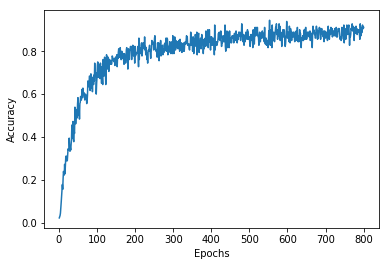

In [145]:
batch_size = 93
epochs = 800
history = fit_generator_1(model, x, y, classes, batch_size, epochs=epochs)
test_1(model, classes, batch_size)
plot_history(history)

In [154]:
x_test, y_test, num_classes = process_file_some_classes('Alexander_cls_test2.csv', classes)
y_predict_classes = model.predict_classes(x_test, batch_size=32) + 1 + classes[0]
y_test_classes = probas_to_classes(y_test) + classes[0]
y_classes = probas_to_classes(y) + classes[0]

160/180 [=========================>....] - ETA: 0s

Confusion matrix, without normalization
[[0 0 0 ..., 3 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


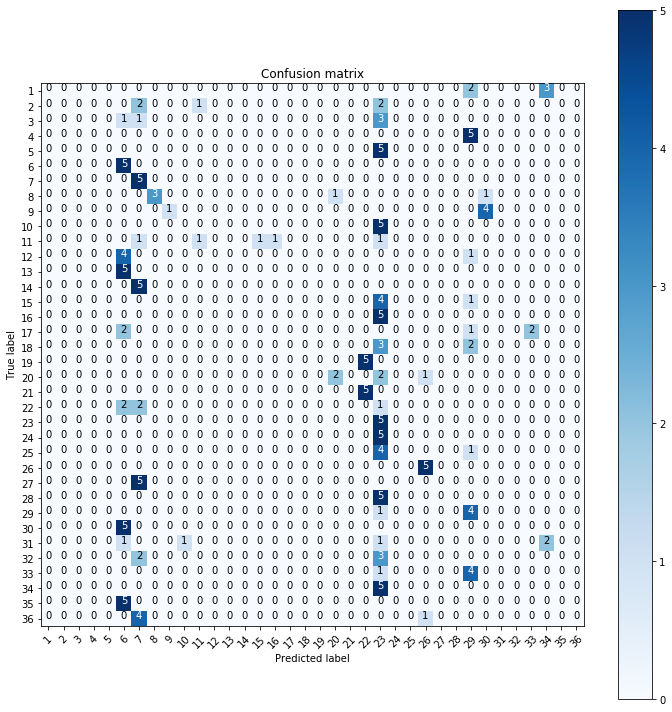

In [155]:
cnf_matrix = confusion_matrix(y_test_classes, y_predict_classes)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_test_classes))
np.set_printoptions(precision=2)
plt.show()

In [132]:
y.shape

(180, 36)

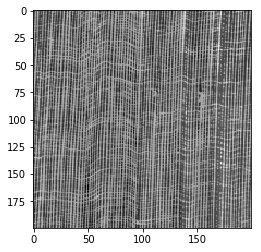

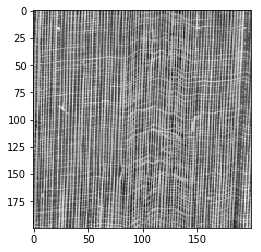

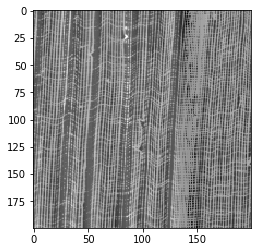

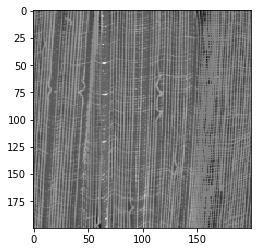

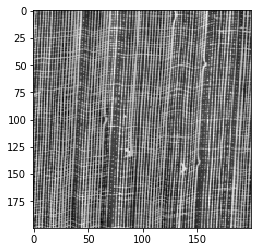

[None, None, None, None, None]

In [152]:
[plot(img) for img in x[y_classes == 8]]

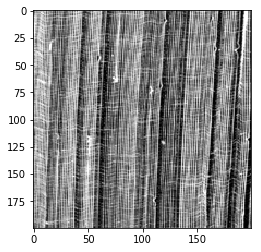

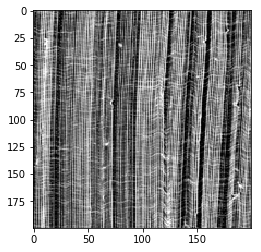

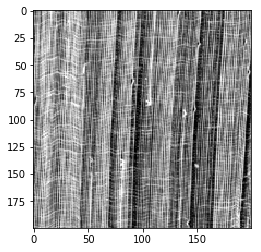

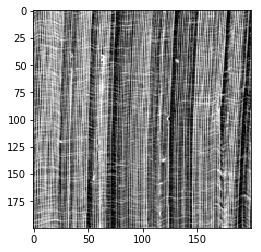

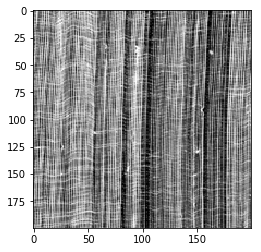

[None, None, None, None, None]

In [153]:
[plot(img) for img in x_test[y_test_classes == 8]]

In [ ]:
np.unique(np.argmax(y_predict, axis=1))

In [ ]:
model = Sequential()
# input: 200x200 grayscale images -> (200, 200, 1) tensors.
# this applies 8 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(200, 200, 1)))
model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (2, 2), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (2, 2), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(512, (2, 2), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
# model.add(Dense(1024, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.01), activation='softmax'), )
model.add(Dropout(0.5))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# model.fit(x, y, batch_size=8, epochs=10, validation_data=(x_train, y_train))
model.fit(x, y, batch_size=32, epochs=500)

In [ ]:
x_test, y_test, num_classes = process_file('Alexander_cls_train.csv')

In [ ]:
batch_size = 20
model.fit_generator(datagen.flow(x, y, batch_size=batch_size),
                    steps_per_epoch=len(x) / batch_size * 10, epochs=500, use_multiprocessing=True, workers=20)

In [ ]:
test_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)

test_datagen.fit(x)

test_paths = ['Alexander_cls_train.csv',
             'Alexander_cls_test.csv',
             'Alexander_cls_test1.csv',
             'Alexander_cls_test2.csv',
             'Alexander_cls_test3.csv',
             'Alexander_cls_test4.csv']

batch_size = 32

for test_path in test_paths:
    x_test, y_test, num_classes = process_file(test_path)
    score = model.evaluate_generator(test_datagen.flow(x_test, y_test, batch_size=batch_size), steps=len(x_test) / batch_size)
    print(test_path + ' : ' + ', '.join(str(x) for x in score))

In [ ]:
model.evaluate(x, y, batch_size=32)

In [ ]:
y_predict = model.predict(x_test, batch_size=32)

In [ ]:
y_predict.shape

In [ ]:
np.argmax(y_test, axis=1).shape

In [ ]:
np.sum(np.argmax(y_predict, axis=1) == np.argmax(y_test, axis=1))/y_predict.shape[0]

In [ ]:
np.unique(np.argmax(y_predict, axis=1))

In [ ]:
model.summary()

In [ ]:
# спросить про 500 samples на класс (хорошо, но можно оверфитнуться)
# когда 50 сэмплов хорошо, обычно плохо